## BFNs for discretized MNIST

In [10]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

import matplotlib.pyplot as plt
%matplotlib inline

### Import the data

In [16]:
import torchvision
import torchvision.transforms as transforms

# Define the data transformation
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,)),  # Normalize the pixel values to [-1, 1]
    transforms.Lambda(lambda x: torch.round((x + 1) / 2).to(torch.int64)) # Discretize data
])

# Download and load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

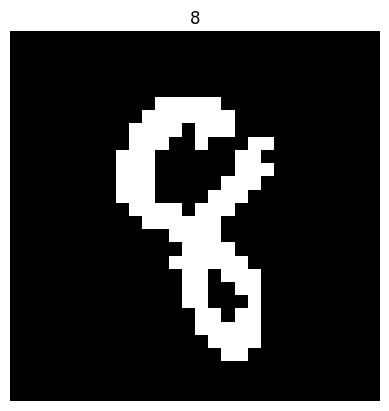

In [107]:
# Show example
for i in train_loader:
  x, y = i
  plt.imshow(x[0][0], cmap='Greys_r', interpolation='nearest')
  plt.axis('off')
  plt.title(y[0].numpy())
  break

### The model

We start by defining the convolutional model. For this project we use a simplified version of the [U-Net](https://papers.labml.ai/paper/2e48c3ffdc8311eba3db37f65e372566) architecture, which has the following structure:

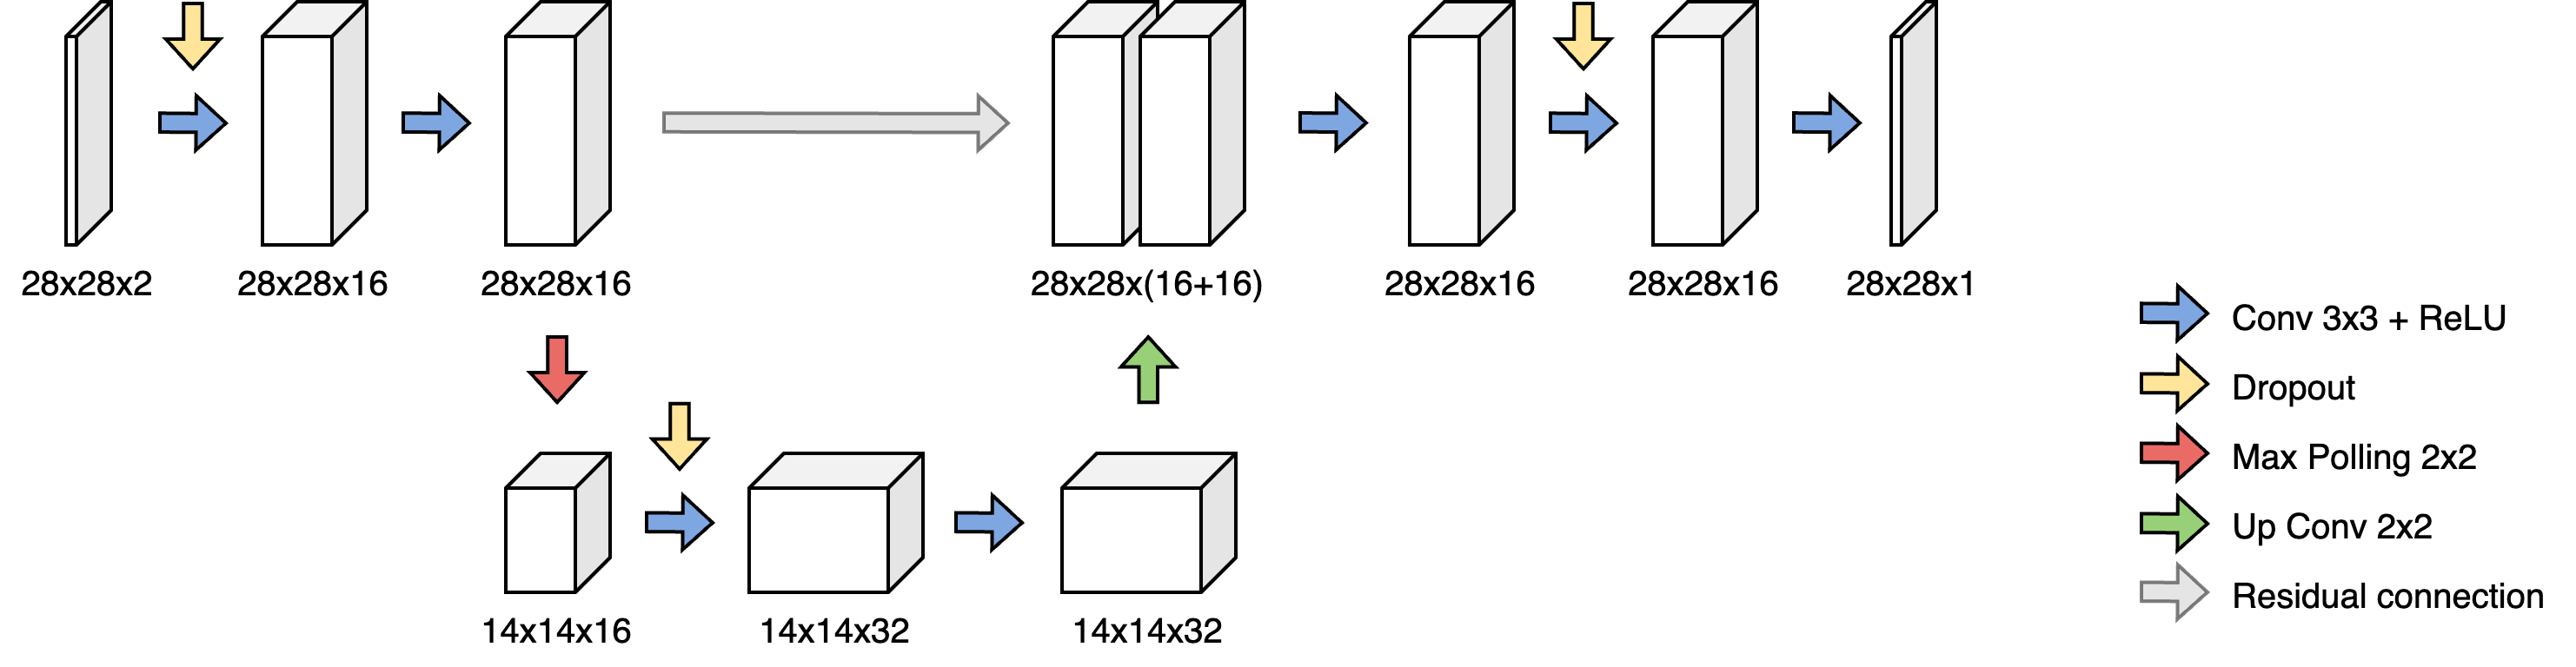

In [27]:
from torch.nn.functional import relu

class UNet(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.3):
        super().__init__()

        # Encoder
        # input: 28x28xIN
        self.e11 = nn.Conv2d(in_ch, 16, kernel_size=3, padding=1) # output: 28x28x16
        self.dp1 = nn.Dropout(p=dropout)
        self.e12 = nn.Conv2d(16, 16, kernel_size=3, padding=1) # output: 28x28x16
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 14x14x16

        # input: 14x14x16
        self.e21 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # output: 14x14x32
        self.dp2 = nn.Dropout(p=dropout)
        self.e22 = nn.Conv2d(32, 32, kernel_size=3, padding=1) # output: 14x14x32

        # Decoder
        # input: 14x14x32
        self.upconv1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2) # output: 28x28x16
        self.d11 = nn.Conv2d(32, 16, kernel_size=3, padding=1) # output: 28x28x16
        self.dp4 = nn.Dropout(p=dropout)
        self.d12 = nn.Conv2d(16, 16, kernel_size=3, padding=1) # output: 28x28x16

        # Output layer
        # input: 28x28x16
        self.outconv = nn.Conv2d(16, out_ch, kernel_size=1) # output: 28x28xOUT

    def forward(self, x):

        # Encoder
        xe11 = self.dp1(relu(self.e11(x)))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = self.dp2(relu(self.e21(xp1)))
        xe22 = relu(self.e22(xe21))

        # Decoder
        xu11 = self.upconv1(xe22)
        xu12 = torch.cat([xu11, xe12], dim=1)
        xd11 = self.dp4(relu(self.d11(xu12)))
        xd12 = relu(self.d12(xd11))

        # Output layer
        out = self.outconv(xd12)

        return out

In [28]:
test = UNet(2, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test.to(device)

summary(test, input_size=(2, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             304
           Dropout-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 16, 28, 28]           2,320
         MaxPool2d-4           [-1, 16, 14, 14]               0
            Conv2d-5           [-1, 32, 14, 14]           4,640
           Dropout-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           9,248
   ConvTranspose2d-8           [-1, 16, 28, 28]           2,064
            Conv2d-9           [-1, 16, 28, 28]           4,624
          Dropout-10           [-1, 16, 28, 28]               0
           Conv2d-11           [-1, 16, 28, 28]           2,320
           Conv2d-12            [-1, 1, 28, 28]              17
Total params: 25,537
Trainable params: 25,537
Non-trainable params: 0
---------------------------------

Then we define the BFN model, adapted for 2D data.

In [99]:
class BayesianFlowNetwork2D(nn.Module):
    def __init__(self, net, D, K, beta=3.0):
        super(BayesianFlowNetwork2D, self).__init__()
        self.beta = beta
        self.D = D
        self.K = K

        self.net = net

    def forward(self, theta, t):
        theta = (theta * 2) - 1  # scaled in [-1, 1]

        theta = torch.transpose(theta, 1, 3)
        output = self.net(theta + t[:, None, None, None])  # (B, D, D, K)

        return torch.transpose(output, 1, 3)

    def discrete_output_distribution(self, theta, t):

        # Forward pass
        output = self.forward(theta, t)

        # Compute the output probabilities accordingly
        if self.K == 2:
            p0_1 = torch.sigmoid(output)  # (B, D, D, 1)
            p0_2 = 1 - p0_1
            p0 = torch.cat((p0_1, p0_2), dim=-1)  # (B, D, D, 2)
        else:
            p0 = torch.nn.functional.softmax(output, dim=-1)
        return p0

    def process(self, x, t=None, training=True):

        # Step 1: Sample t from U(0, 1)
        if t is None:
          t = torch.rand((x.size(0),), device=x.device, dtype=torch.float32)
        else:
          t = torch.tensor(t, device=x.device, dtype=torch.float32)[None]

        # Step 2: Calculate Beta
        beta = self.beta * (t ** 2)  # (B,)

        # Step 3: Sample y from N(beta * (K * one_hot(X))
        one_hot_x = F.one_hot(x.permute(0, 2, 3, 1), num_classes=self.K).float().squeeze()  # (B, D, D, K)
        mean = beta[:, None, None, None] * (self.K * one_hot_x - 1)
        std = (beta * self.K)[:, None, None, None].sqrt()
        eps = torch.randn_like(mean)
        y = mean + std * eps

        # Step 4: Compute the Theta
        theta = F.softmax(y, dim=-1)

        # Step 5: Calculate the output distribution
        p_0 = self.discrete_output_distribution(theta, t)  # (B, D, D, K)

        e_x = one_hot_x
        e_hat = p_0  # (B, D, D, K)
        L_infinity = self.K * self.beta * t[:, None, None, None] * ((e_x - e_hat) ** 2)
        if training:
          return L_infinity.mean()
        else:
           k = torch.distributions.Categorical(probs=p_0).sample()
           return L_infinity.mean(), y, k, t

    @torch.inference_mode()
    def sample(self, batch_size=128, nb_steps=10, device='cpu'):
        self.eval()

        # get prior
        theta = torch.ones((batch_size, self.D, self.D, self.K), device=device) / self.K

        for i in tqdm(range(1, nb_steps+1)):
            t = (i-1) / nb_steps
            t = t * torch.ones((theta.shape[0]), device=theta.device, dtype=theta.dtype)

            k_probs = self.discrete_output_distribution(theta, t)  # (B, D, D, K)
            k = torch.distributions.Categorical(probs=k_probs).sample()  # (B, D, D)

            alpha = self.beta * (2 * i - 1) / (nb_steps ** 2)

            e_k = F.one_hot(k, num_classes=self.K).float()  # (B, D, D, K)
            mean = alpha * (self.K * e_k - 1)
            var = (alpha * self.K)
            std = torch.full_like(mean, fill_value=var).sqrt()
            eps = torch.randn_like(e_k)

            y = mean + std * eps  # (B, D, D, K)

            theta_prime = torch.exp(y) * theta
            theta = theta_prime / theta_prime.sum(-1, keepdim=True)

        k_probs_final = self.discrete_output_distribution(theta, torch.ones_like(t))
        k_final = torch.distributions.Categorical(probs=k_probs_final).sample()

        return k_final

In [100]:
from torch.optim import AdamW
from tqdm.auto import tqdm

bfn = BayesianFlowNetwork2D(UNet(2, 1, dropout=0.5), 28, 2)
bfn.cuda()

optim = AdamW(bfn.parameters(), lr=1e-4, betas=(0.9, 0.98), weight_decay=0.01)

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

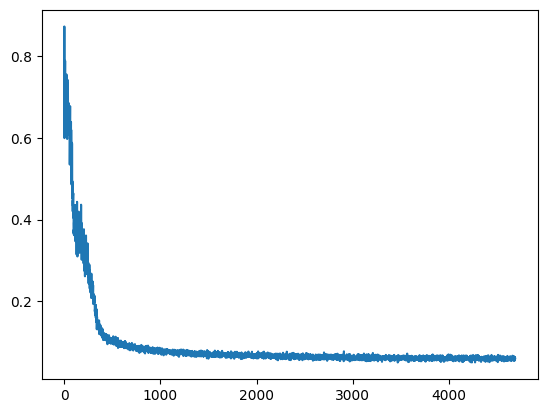

In [101]:
losses = []

epochs = 5

for i in range(epochs):
  for X, _ in tqdm(train_loader):
      optim.zero_grad()

      loss = bfn.process(X.to(device))
      loss.backward()

      optim.step()

      losses.append(loss.item())

plt.plot(losses)

### Sample generation

Once the model has been trained, we can generate some new images.

In [102]:
x_hat = bfn.sample(device='cuda', nb_steps=3000, batch_size=16)

  0%|          | 0/3000 [00:00<?, ?it/s]

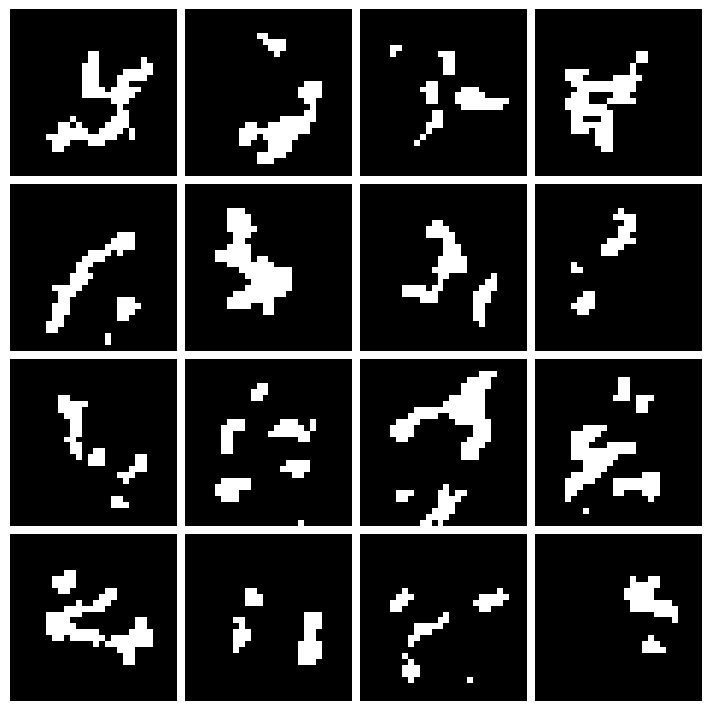

In [103]:
fig, ax = plt.subplots(4, 4, figsize=(7, 7),  layout='constrained')

for i in range(16):
    ax[i // 4, i % 4].imshow(x_hat.cpu().numpy()[i], cmap='Greys_r')
    ax[i // 4, i % 4].axis('off')

We can also observe how the network process images at different values of t.

In [108]:
def get_sample():
  for i in train_loader:
    x, y = i
    break
  return x

In [113]:
x_0 = get_sample()[0][0]

Ys = []
Ks = []
Ts = []

# We set t going from 0 to 2/3
for t in np.linspace(0.001, 0.667, 20):
  l, y, k, t_ = bfn.process(x_0[None, :, :, None].to(torch.int64).to(device), training=False, t=t)

  Ys.append(y.permute(0, 2, 1, 3).cpu().numpy()[0, :, :, 1])
  Ks.append(k.permute(0, 2, 1).cpu().numpy()[0])
  Ts.append(t)

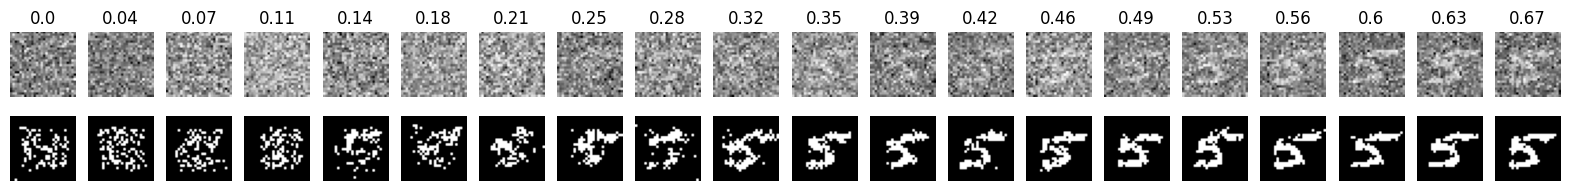

In [114]:
fig, ax = plt.subplots(2, 20, figsize=(20, 2))

for i in range(20):
  ax[0, i].imshow(Ys[i], cmap='Greys_r')
  ax[1, i].imshow(Ks[i], cmap='Greys_r')
  ax[0, i].axis('off')
  ax[1, i].axis('off')

  ax[0, i].set_title(np.round(Ts[i], 2))